In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = 'cerberus_annot_triplets.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']

In [3]:
ca = cerberus.read('cerberus_annot_triplets.h5')
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'

mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']
mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
subset = {'source': ['v40', 'obs_det', 'sample_major']}

## % genes in each sector per tissue

In [4]:
source = 'sample_det'
obs_source = 'obs_det'

In [5]:
df = ca.triplets.loc[ca.triplets.source == source]
# df = assign_gisx_sector(df)
# df.head()

df = compute_genes_per_sector(df, ['sample'])

In [7]:
df.loc[df['sample'] == 'a673']

,sector,sample,n_genes,total_genes,perc
0,mixed,a673,5327,12634,42.164002
50,simple,a673,3352,12634,26.531581
100,splicing,a673,1729,12634,13.685294
150,tes,a673,1783,12634,14.112712
200,tss,a673,443,12634,3.506411


<Figure size 360x288 with 0 Axes>

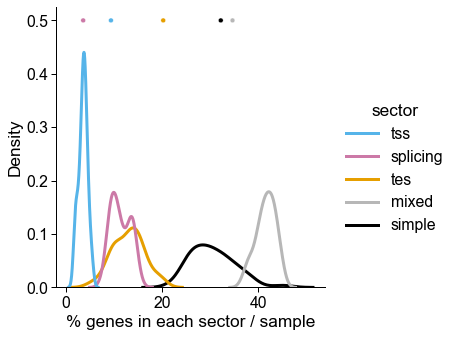

In [20]:
# def plot_perc_genes_per_sector_kde(ca, source, obs_source):
df = ca.triplets.loc[ca.triplets.source == source]
# df = assign_gisx_sector(df)
# df.head()

df = compute_genes_per_sector(df, ['sample'])
# df = df[['gid', 'sample', 'sector']].groupby(['sector', 'sample']).count().reset_index()
# df.rename({'gid':'n_genes'}, axis=1, inplace=True)
# df['total'] = np.nan
# for s in df['sample'].unique().tolist():
#     inds = df['sample'] == s
#     df.loc[inds, 'total'] = df.loc[inds, 'n_genes'].sum()

# df['perc'] = (df.n_genes/df.total)*100

c_dict, order = get_sector_colors()

# plotting
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(5,4))

ax = sns.displot(data=df, x='perc', kind='kde',
                     linewidth=3, common_norm=False, hue='sector',
                     palette=c_dict, hue_order=order)
xlabel = '% genes in each sector / sample'
ylabel = 'Density'
xlim=None

if xlim:
    _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,xlim))
else:
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    
obs_df = ca.triplets.loc[ca.triplets.source == obs_source]
obs_df = compute_genes_per_sector(obs_df, gb_cols=['source'])
ax = sns.scatterplot(data=obs_df, x='perc', y=0.5, hue='sector', palette=c_dict)
ax.legend_.remove()

<Figure size 360x288 with 0 Axes>

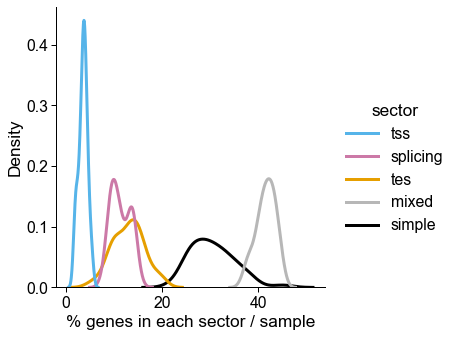

In [92]:
plot_perc_genes_per_sector_kde(ca, 'sample_det')

<Figure size 360x288 with 0 Axes>

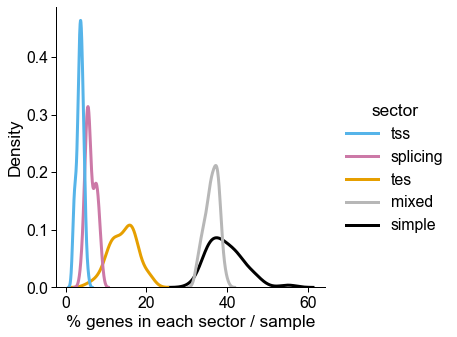

In [93]:
plot_perc_genes_per_sector_kde(ca, 'sample_major')

     sector  n_genes       perc
0     mixed     7397  42.950877
1    simple     5511  31.999768
2  splicing     1578   9.162699
3       tes     1811  10.515620
4       tss      925   5.371037


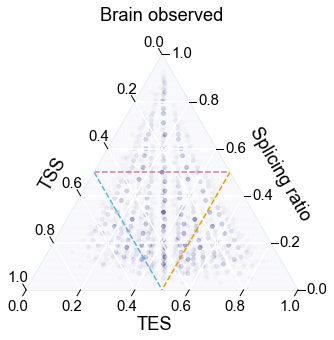

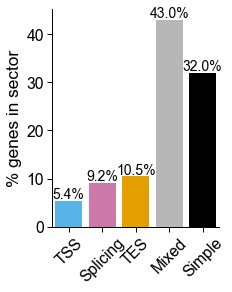

In [76]:
# brain 
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_det', 'sample': 'brain'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Brain observed',
            size_scale=0.5,
            density_cbar=False,
            fname='figures/simplex_brain_obs.pdf')
plot_genes_per_sector(temp)

In [ ]:
# brain 
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_major', 'sample': 'brain'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Brain observed major',
            size_scale=1,
            density_cbar=False,
            fname='figures/simplex_brain_obs_major.pdf')
plot_genes_per_sector(temp)

     sector  n_genes       perc
0     mixed     6239  43.209364
1    simple     3829  26.518457
2  splicing     1983  13.733638
3       tes     1863  12.902556
4       tss      525   3.635986


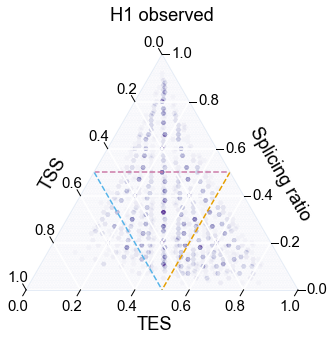

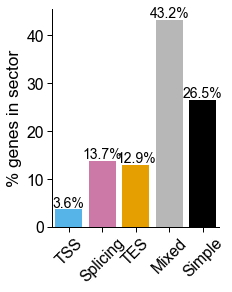

In [75]:
# h1 
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_det', 'sample': 'h1'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='H1 observed',
            size_scale=0.5,
            density_cbar=False,
            fname='figures/simplex_h1_obs.pdf')
plot_genes_per_sector(temp)

In [67]:
# which genes become TES-high in the brain after being ES cells? 
samples = ['h1', 'brain'] 
sources = ['sample_det']
temp = ca.triplets.loc[(ca.triplets['sample'].isin(samples))&(ca.triplets['source'].isin(sources))]
temp = assign_gisx_sector(temp)
temp = temp[['gid', 'gname', 'sample', 'sector']]

df = pd.DataFrame()
for i, s in enumerate(samples): 
    if i == 0:
        df = temp.loc[temp['sample'] == s]
    else:
        df = df.merge(temp.loc[temp['sample'] == s], how='outer',
                      on=['gid', 'gname'], suffixes=('_'+samples[i-1], '_'+s))
    
    




In [70]:
df.loc[(df['sector_h1']!='tes')&(df['sector_brain']=='tes')]
df.loc[(df['sector_h1']=='tes')&(df['sector_brain']=='tes')]

,gid,gname,sample_h1,sector_h1,sample_brain,sector_brain
9,ENSG00000001461,NIPAL3,h1,tes,brain,tes
11,ENSG00000001561,ENPP4,h1,tes,brain,tes
41,ENSG00000004455,AK2,h1,tes,brain,tes
46,ENSG00000004700,RECQL,h1,tes,brain,tes
52,ENSG00000004897,CDC27,h1,tes,brain,tes
...,...,...,...,...,...,...
14270,ENSG00000277283,ENSG00000277283,h1,tes,brain,tes
14272,ENSG00000277443,MARCKS,h1,tes,brain,tes
14284,ENSG00000278053,DDX52,h1,tes,brain,tes
14294,ENSG00000278311,GGNBP2,h1,tes,brain,tes


In [71]:
def plot_genes_per_sector(df):
    
    temp = df.copy(deep=True)
    
    # count the number of genes in each sector
    temp = compute_genes_per_sector(temp, [])
    # temp = assign_gisx_sector(temp)
    # temp = temp[['gid', 'sector']].groupby('sector').count().reset_index()
    # temp.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    # temp['perc'] = (temp.n_genes/temp.n_genes.sum())*100
    # print(temp)
        
    c_dict, order = get_sector_colors()
    
    # plotting
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(3,4))
    ax = sns.barplot(data=temp, y='perc', x='sector', palette=c_dict, order=order, saturation=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    ylabel = '% genes in sector'
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    xticks = [cat.capitalize() if cat not in ['tss', 'tes'] else cat.upper() for cat in order]
    ax.tick_params(axis="x", rotation=45)    
    ax.set_xticklabels(xticks)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            # x = p.get_x() + p.get_width() / 2 - 0.3
            # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(percentage, (x, y), size=14, horizontalalignment='center')

    add_perc_2(ax)